# Regression

## *Workshop 8*  [![Open In Colab](https://github.com/oballinger/QM2/blob/main/colab-badge.png?raw=1)](https://colab.research.google.com/github/oballinger/QM2/blob/main/notebooks/W08.%20Regression.ipynb)

### Aims:

- Choosing appropriate summary statistics for varying distributions

- Understanding:
    - The nature of our dataset, including potential bias
    - How to generate summary statistics for our dataset
    - The distribution of different variables
    - The intuition behind the Central Limit Theorem

## Getting Started

### First Things First: Bias
Once we've acquired a dataset, the first step is *always* to develop an understanding of where the data has come from. For this dataset, use the following [documentation page](https://www.census.gov/programs-surveys/cps/technical-documentation/methodology.html) to answer the questions below: 

1) What is the population of interest?
2) What was the sampling strategy?
3) What are potential sources of selection bias?

I'll start by importing the libraries I need: matplotlib (for graphs), pandas (for data), numpy (for maths) and random (for generating random numbers):

In [236]:
#This tells python to draw the graphs "inline" - in the notebook
%matplotlib inline  
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
import statistics 
import seaborn as sns

import pylab
import pandas as pd
import numpy as np
# make the plots (graphs) a little wider by default
pylab.rcParams['figure.figsize'] = (10., 8.)


In [237]:
!mkdir data
!mkdir data/wk8
!curl https://storage.googleapis.com/qm2/wk7/cps.csv -o data/wk8/cps.csv

mkdir: data: File exists
mkdir: data/wk8: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22.4M  100 22.4M    0     0  3271k      0  0:00:07  0:00:07 --:--:-- 3648k


Now that I've imported the libraries I'm going to be using, I'm ready to import the data: 

In [238]:
df=pd.read_csv('./data/wk7/cps.csv')
df.head()

,year,state,age,sex,race,sch,ind,union,incwage,realhrwage,occupation
0,1990,36,58,1,3,12.0,871,0.0,14200.0,12.269874,Office and Admin Support
1,2009,5,28,1,1,12.0,8660,1.0,17680.0,8.635149,Office and Admin Support
2,1990,36,37,1,1,14.0,380,1.0,28000.0,21.169851,.
3,1990,6,34,1,1,18.0,740,1.0,27500.0,20.447746,Computer and Math Technicians
4,1981,51,38,1,4,13.0,798,NaN,17000.0,18.892282,Managers


Our dataframe has 10 columns:

1. *year*: Survey year
2. *age*: the person's age
3. *sex*: the person's sex 
    * 1=male
    * 2=female
4. *race*: the person's race 
    * White non hispanic=1
    * Black non hispanic=2
    * Hispanic=3
    * Other non hispanic=4)
5. *sch*: Educational attainment
    * None = 0, 
    * Grades 1-12 = 1-12
    * Some University = 13, 
    * Associate's degree = 14, 
    * BA = 16
    * Advanced Degree = 18
6. *union*: Union membership 
    * N/A = 0, 
    * No union coverage = 1, 
    * Member of labor union=2, 
    * Covered by union but not a member=3
7. *incwage*: Wage and salary income
8. *realhrwage*: Real Hourly Wage
9. *occupation*: Occupation
10. *ind*: [industry code](https://www.census.gov/naics/?58967?yearbck=2002)


## Summary Statistics

After thinking about the origins of our dataset and loading it into python, the next step is to generate summary statistics. This is vital for us to better understand our data. Pandas has a useful function, `describe`, which will generate summary statistics for all numerical variables in our entire dataframe:

In [239]:
df.dtypes


year            int64
state           int64
age             int64
sex             int64
race            int64
sch           float64
ind             int64
union         float64
incwage       float64
realhrwage    float64
occupation     object
dtype: object

In [240]:
reg_df=df[df['year']==2013]
reg_df[['race','union','sex','occupation']]=reg_df[['race','union','sex','occupation']].astype('category', )
reg_df[['realhrwage','sch','age','sex','race','union','ind']].describe()

/Users/ollieballinger/.pyenv/versions/3.9.5/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,realhrwage,sch,age,ind
count,53790.000000,53790.000000,53790.000000,53790.000000
mean,24.381761,13.925851,42.909779,6363.972188
std,151.904349,2.738845,10.557340,2612.374440
min,2.005738,0.000000,25.000000,170.000000
25%,12.170889,12.000000,34.000000,4870.000000
50%,18.440742,13.000000,43.000000,7380.000000
75%,28.122131,16.000000,51.000000,8190.000000
max,34760.796875,18.000000,64.000000,9590.000000


Notice the max value for real hourly wage. Someone is making $34,760 per hour, must be nice (or, may be a data entry error). Either way, because regresisons are sensitive to this sort of outlier, we should remove it. 

In [313]:
def filter_outliers(var):
    q1 = var.quantile(0.25) # calculate the first quartile
    q3 = var.quantile(0.75) # calculate the third quartile
    iqr = q3 - q1 # calculate the interquartile range
    low = q1 - 3*iqr # calculate the lower bound
    high = q3 + 3*iqr # calculate the upper bound
    filtered = reg_df[(var > low) & (var < high)] # filter  the values that are within the bounds
    dropped_observations= len(var)-len(filtered) # calculate the number of observations that were dropped
    print('Dropped {} observations'.format(dropped_observations))
    return  filtered

#reg_df['realhrwage']=filter_outliers(reg_df['realhrwage'])
wage_filtered=filter_outliers(reg_df['realhrwage'])
wage_filtered=filter_outliers(reg_df['incwage'])


Dropped 1070 observations
Dropped 1208 observations


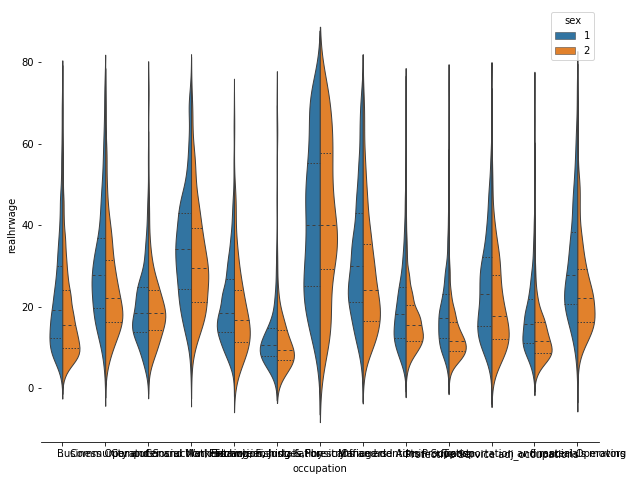

In [242]:
sns.violinplot(data=reg_df, x="occupation", y="realhrwage", hue="sex",
               split=True, inner="quart", linewidth=1)

sns.despine(left=True)


## Dummy Variables


In [243]:
race_columns = pd.get_dummies(reg_df['race'], prefix='race')
race_columns.describe()

,race_1,race_2,race_3,race_4
count,53790.000000,53790.000000,53790.000000,53790.000000
mean,0.644395,0.102975,0.170125,0.082506
std,0.478701,0.303928,0.375746,0.275137
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [244]:
occupation_columns = pd.get_dummies(reg_df['occupation'], prefix='occ')
occupation_columns.describe()

,occ_.,occ_Business Operators,occ_Community and Social Workers,occ_Computer and Math Technicians,"occ_Consruction, Extraction, Installation","occ_Farming, Fishing & Forestry","occ_Lawyers, Judges,Physicans and dentists",occ_Managers,occ_Office and Admin Support,occ_Production,occ_Protective Service adj_occupations,occ_Transportation and materials moving,occ_financial Operators
count,53790.000000,53790.000000,53790.000000,53790.000000,53790.000000,53790.000000,53790.000000,53790.000000,53790.000000,53790.000000,53790.000000,53790.000000,53790.000000
mean,0.403421,0.025042,0.019688,0.033705,0.082952,0.006563,0.013144,0.107715,0.134598,0.064380,0.024707,0.059249,0.024837
std,0.490588,0.156254,0.138926,0.180471,0.275813,0.080744,0.113891,0.310023,0.341296,0.245431,0.155233,0.236092,0.155631
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


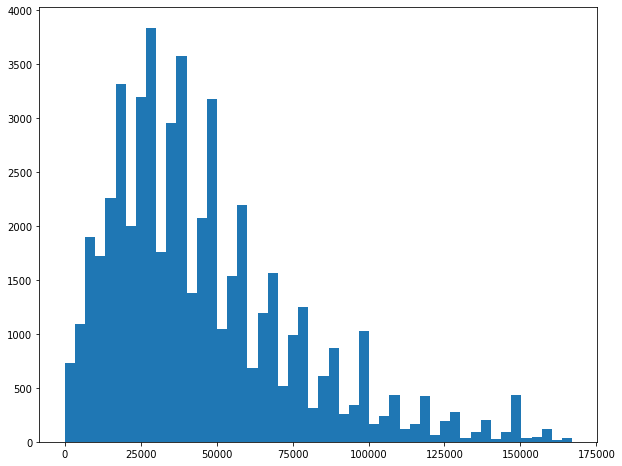

In [315]:
plt.hist(wage_filtered['incwage'],bins=50)
plt.show()

(array([6.0000e+00, 1.3000e+01, 3.3000e+01, 1.2100e+02, 3.4300e+02,
        1.1870e+03, 4.2410e+03, 1.5446e+04, 2.3316e+04, 8.0380e+03]),
 array([ 3.63758616,  4.48334165,  5.32909714,  6.17485264,  7.02060813,
         7.86636362,  8.71211911,  9.55787461, 10.4036301 , 11.24938559,
        12.09514108]),
 <BarContainer object of 10 artists>)

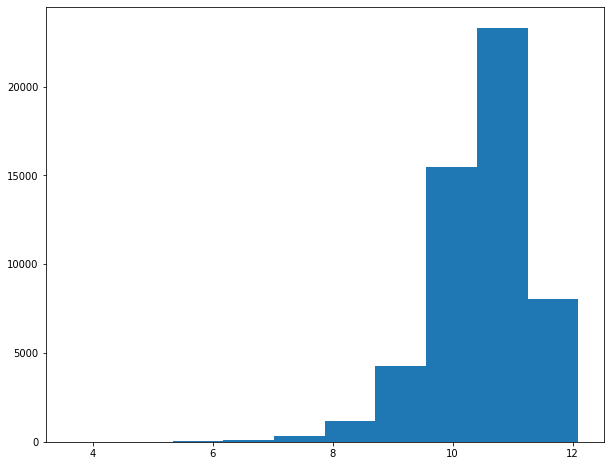

In [291]:

plt.showplt.histreg_df['incwage'])


Index(['year', 'state', 'age', 'sex', 'race', 'sch', 'ind', 'union', 'incwage',
       'realhrwage', 'occupation', 'ln_wage', 'ln_sch'],
      dtype='object')
count     52582.000000
mean      45892.719086
std       31124.196017
min          38.000000
25%       24000.000000
50%       39075.000000
75%       60000.000000
max      167000.000000
Name: incwage, dtype: float64


/Users/ollieballinger/.pyenv/versions/3.9.5/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


                            OLS Regression Results                            
Dep. Variable:                incwage   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     4473.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        14:08:08   Log-Likelihood:                -57394.
No. Observations:               52582   AIC:                         1.148e+05
Df Residuals:                   52578   BIC:                         1.148e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sch            0.1141      0.001     98.398      0.0

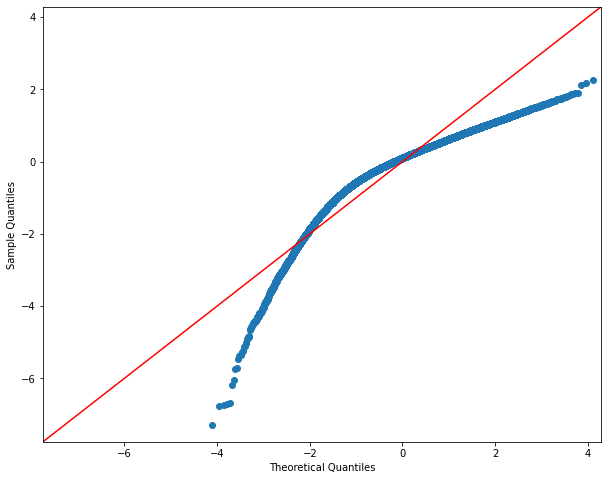

In [316]:
print(reg_df.columns)
print(wage_filtered['incwage'].describe())
y=np.log(wage_filtered['incwage'])
x=sm.add_constant(wage_filtered[['sch','age','sex']], prepend=False)
#x=df[['incwage']]
x_b=sm.add_constant(x, prepend=False)
mod = sm.OLS(y, x_b, missing='drop')
res=mod.fit()

residuals = res.resid
sm.qqplot(residuals, line='45',color='black')
#sm.residual_plot(residuals)

print(res.summary())
plt.show()


In [327]:
reg_df['ln_wage']=np.log(reg_df['realhrwage'])
reg_df['ln_sch']=np.log(reg_df['sch'])

fig = plt.figure(figsize=(14, 8))

fig = sm.graphics.plot_regress_exog(linear_model,
                                    'Head_size',
                                    fig=fig)

sns.lmplot(
    data=reg_df.sample(1000), x="sch", y="ln_wage",
    scatter_kws={'alpha':0.3})

/var/folders/6q/jt4x0r8n1rs0kbrrqrbj61fr0000gn/T/ipykernel_99061/726669051.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_df['ln_wage']=np.log(reg_df['realhrwage'])
/Users/ollieballinger/.pyenv/versions/3.9.5/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/6q/jt4x0r8n1rs0kbrrqrbj61fr0000gn/T/ipykernel_99061/726669051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_df

NameError: name 'linear_model' is not defined

<Figure size 1008x576 with 0 Axes>

`describe` returns a dataframe with the same columns as the source dataframe. For numeric data, the result’s index will include count, mean, std, min, max as well as lower, 50 and upper percentiles. By default the lower percentile is 25 and the upper percentile is 75. The 50 percentile is the same as the median. "incwage" is the annual income variable. Because values are generally in the tens of thousands, Python displays this using scientific notation (e.g. 3.442870e+05). This is pretty ugly, so let's create a new variable called "income" which divides that number by 1000 to make it more manageable:

In [ ]:
df['income']=df['incwage']/1000
print(df['income'])

20        57.0
32        62.0
34        45.0
36        28.0
37        42.5
          ... 
344244    14.5
344269    23.0
344278    45.0
344281    23.0
344286    15.0
Name: income, Length: 53205, dtype: float64



### Exercise
Given these summary statistics, answer the following questions: 

1. what is the median hourly wage?
2. what is the average age?
3. are there more men or women?
4. intepret the mean of the "race" column. 


The answer to the last question should provoke some futher thought; the race column is categorical, but because it contains numbers it's being treated as numerical. The mean of a categorical variable is meaningless; For object data (e.g. categories, strings or timestamps), the result’s index will include count, unique, top, and freq. The top is the most common value. The freq is the most common value’s frequency. Timestamps also include the first and last items.

Let's convert the race column from a numerical variable into a categorical one, and try `describe` once again:

In [ ]:
df.dtypes

year            int64
state           int64
age             int64
sex             int64
race            int64
sch           float64
ind             int64
union         float64
incwage       float64
realhrwage    float64
occupation     object
income        float64
dtype: object

In [ ]:
df[['race','ind','union','occupation']]=df[['race','ind','union','occupation']].astype('category')
df.dtypes


year             int64
state            int64
age              int64
sex              int64
race          category
sch            float64
ind           category
union         category
incwage        float64
realhrwage     float64
occupation    category
const          float64
income         float64
dtype: object

what other variables are categorical? Convert them to categorical and describe. What is the most common occupation in this dataset?

In [ ]:
# convert the variables to categorical and describe

These statistics are useful, but suppose we want detailed counts of the number of individuals in each category; For this, we can use the `groupby` function, with the `.size()` operator which simply counts the number of rows in each category. 

In [ ]:
occupations= df.groupby('occupation').size()
occupations.sort_values(ascending=False)

occupation
.                                         132708
Office and Admin Support                   50635
Managers                                   35696
Consruction, Extraction, Installation      30579
Production                                 29732
Transportation and materials moving        21277
Computer and Math Technicians               8602
Protective Service adj_occupations          7809
financial Operators                         7702
Business Operators                          7327
Community and Social Workers                6025
Lawyers, Judges,Physicans and dentists      3835
Farming, Fishing & Forestry                 2360
dtype: int64

What is the most common profession? 


# Distributions

Now that we've cleaned our data up, let's have a closer look at the *distribution* of our data. The best way to do this is using a histogram, which takes one variable and divides its values into a number of bins shown on the X axis, and then counts the number of observations in each of those bins on the Y axis. Let's start by looking at the distribution of the `income` variable:

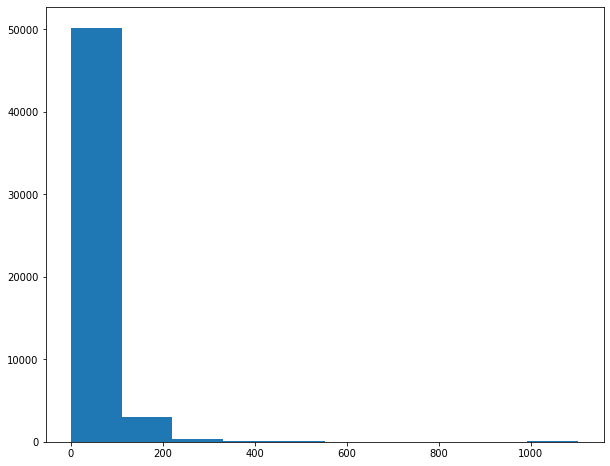

In [ ]:
df=df[df['year']==2013] # filter the dataframe to only contain 2013 data

plt.hist(df['income']) # plot a histogram of the income variable
plt.show() # show the plot

This is a pretty ugly histogram, and it's not telling us very much useful information. It shows that the vast majority of people make between 0 and $100,000 per year, and a few make over 200k. A small number make over $1 million per year, so the plot is being extended to accomodate these outliers. Let's try fixing the histogram up a bit. 

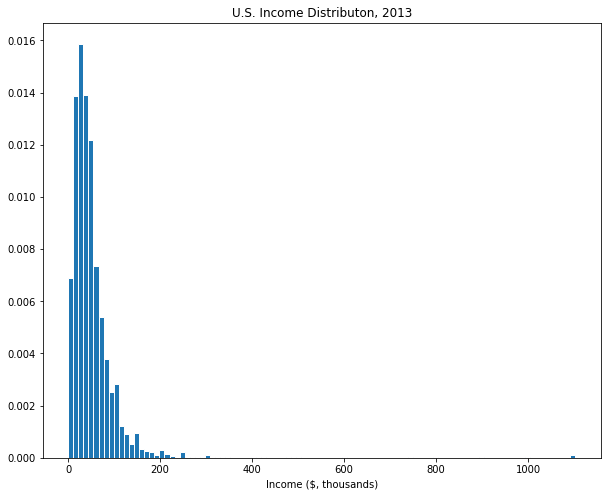

In [ ]:
plt.hist(df['income'], bins=100, edgecolor='white', density=True) 
# i've increased the number of bins to 100 to make the plot smoother,
# added the density=True argument to make the y-axis a probability density instead of a count,
# and the edgecolor='white' argument to add some space between the bars, making the plot easier to read


plt.xlabel('Income ($, thousands)') # add a label to the x axis
plt.title("U.S. Income Distributon, 2013") # add a title to the plot

plt.show() 

That's better. We can now see more variation in how much people earn within the \$0\-200,000 range since we increased the number of bins in the histogram. It could still be improved, though. The outliers making over $ 1 million are creating lots of dead space in this plot. We can defensibly omit them from the plot, as long as we acknowledge that we've done this somewhere in our analysis. 

Let's also plot the mean and median of our distribution. 

In [ ]:
inc_summary=df['income'].describe() # get summary statistics for the income variable using the describe() method, and store them in a variable called inc_summary
print(inc_summary[['mean','50%','std']]) # print the mean, median and standard deviation

plt.hist(df['income'], bins=100, edgecolor='white', density=True) # plot the histogram again
plt.axvline(inc_summary['mean'], color='red', linestyle='dashed', linewidth=1,label='Mean') # get the mean from the inc_summary variable and plot a vertical line in red at that point
plt.axvline(inc_summary['50%'], color='black', linestyle='dashed', linewidth=1, label='Median') # do the same for the median, but plot it in black

plt.legend()
plt.xlabel('Income ($, thousands')
plt.title("U.S. Income Distributon, 2013")
plt.xlim(0,250) # set the x-axis limits to 0 to 250-- this will get rid of the outliers on the right side of the plot

plt.show()

KeyError: 'income'

This histogram is far more informative-- use the questions in the exercise below to guide your interpretation of this plot. 

### Exercise

1. What is the (approximate) mean of this distribution? 
2. What is the median? 
3. Keeping in mind that we've excluded some extreme values, why might the mean be larger than the median? Intepret this qualitatively in reference to income inequality. 
4. There are slight bumps in density at $100,000, $150,000, $200,000, and $250,000. Why might this be?

## Functions 

Now we've got a pretty good sense of what's going on with the income variable. But suppose we want to do this for another variable. We could just copy and paste the code above, switch around the variable in question, and edit the labels. But there's a far more efficient way of doing things. In Python and most programming languages, you can write your own **function**. 

A function is a block of code that you can call on to do a specific task. You can write your own functions, or you can use functions that other people have written. Functions are useful because they allow you to write code once, and then call on it whenever you need it. This is much more efficient than writing the same code over and over again. You can define a function by using the `def` keyword. For example, we can define a function called `variable_stats` that will calculate the mean, median, and standard deviation of the variable tha you specify. 

In [ ]:
def variable_stats(variable): # define a function called variable_stats that takes a variable as an argument
    mean = variable.mean() # calculate the mean of the variable
    median = variable.median() # calculate the median of the variable
    std = variable.std() # calculate the standard deviation of the variable
    print("Mean: " + str(mean)) # print the mean
    print("Median: " + str(median)) # print the median
    print("Standard deviation: " + str(std)) # print the standard deviation

In [ ]:
# We can then call on this function whenever we want to calculate these statistics. 

variable_stats(df['income']) 

Mean: 51.821862558096306
Median: 40.0
Standard deviation: 60.163449180529874


Now, to calculate the same values for the age variable, we can simply change which variable we feed the function:

In [ ]:
variable_stats(df['age']) 

Mean: 42.909778769287975
Median: 43.0
Standard deviation: 10.557339619953297


We can write a more complex function to deal with plotting new histograms for different variables, since most of the code we need to plot a histogram won't change from one variable to the next. A few things will change-- the variable that we're plotting, the title of the graph, and the labels on the x and y axes, and perhaps the number of bins. We can write a function called `plot_histogram`  that takes these four things as arguments, and then plots a histogram. Then, we can call on this function whenever we want to plot a histogram of a new variable. Below is the same code we used to plot the histogram of income, but this time we've written it as a function called `plot_histogram` and substituted the variable name `income` for the argument `variable`.

In [ ]:
def plot_histogram(variable, bin_number, xlab, title): # define a function called plot_histogram that takes a variable, number of bins, x-axis label, and title as arguments
	
	summary=variable.describe() 	
	plt.hist(variable, bins=bin_number,edgecolor='white', density=True) # plot the histogram. Notice i've changed "bins=100" to "bins=bin_number" so that the number of bins can be specified when the function is called
	plt.axvline(summary['mean'], color='red', linestyle='dashed', linewidth=1,label='Mean '+str(round(summary['mean'],2)))
	plt.axvline(summary['50%'], color='black', linestyle='dashed', linewidth=1, label='Median '+str(round(summary['50%'],2)))

	plt.legend()
	plt.xlabel(xlab) # i've changed the x-axis label to "xlab" so that it can be specified when the function is called
	plt.title(title) # similarly, we can now specify the title when calling the function
	plt.show()

Now we can just call the function with the variable we want to plot, the number of bins, the x-axis label, and the title using one line of code. Let's recreate the histogram of income from above, but this time using the function we just defined:


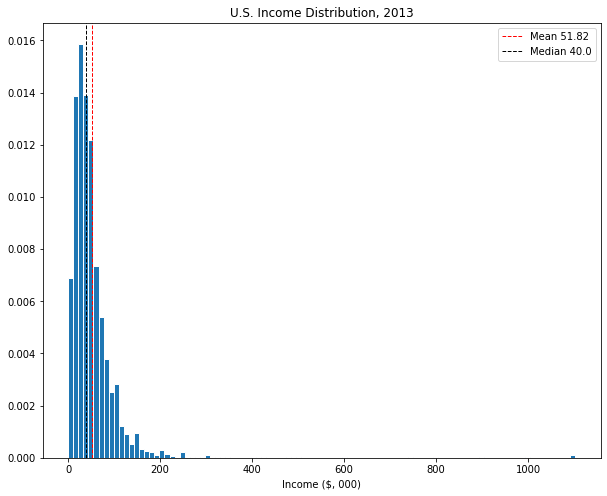

In [ ]:
plot_histogram(variable = df['income'], bin_number = 100, xlab = 'Income ($, 000)', title = 'U.S. Income Distribution, 2013')

If we want to produce lots of similar plots, this really helps us cut down on repetition.

### Exercise

1. Plot the histogram of the 'age' variable with 80 bins, label the x-axis "Age", and add title of 'U.S. Age Distribution, 2013'.
2. Plot the distribution of schooling years.
    * Find an appropriate number of bins
    * Label it clearly
    * Interpret salient trends

## The Central Limit Theorem

But as we learned in class, the Central Limit Theorem states that the **distribution of the mean of a sample of observations will be approximately normal, regardless of the distribution of the original observations**. So, if we take a **large enough sample** of observations from each of these variables, and calculate the mean of each sample, we should get a normal distribution. This is important because the normal distribution behaves in a very predictable way. 

The code below creates a "standard normal" distribution with a mean of 0 and a standard deviation of 1:

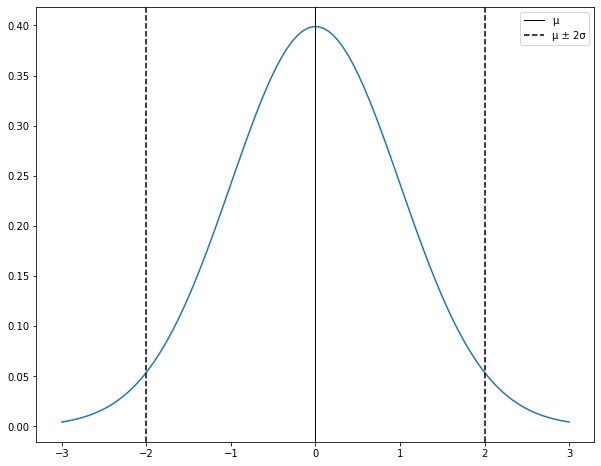

In [ ]:
mu, se= 0, 1 # create two variables, a mean "mu" equal to zero, and standard deviation "se" equal to 1
x = np.linspace(mu - 3*se, mu + 3*se, 100) # create a range of values from -3 to 3 standard deviations

plt.plot(x, norm.pdf(x, mu, se)) # plot the normal distribution
plt.axvline(mu, color='black', linestyle='solid', linewidth=1,label='µ')  # plot a vertical line at the mean
plt.axvline(mu-se*2, color='black', linestyle='dashed', linewidth=1.5,label='µ ± 2σ') # plot a vertical line at the mean plus 2 standard deviations
plt.axvline(mu+se*2, color='black', linestyle='dashed', linewidth=1.5)  # plot a vertical line at the mean minus 2 standard deviations
plt.legend()
plt.show()

for a distribution with this shape,

    * 68% of the values will be within 1 standard deviation of the mean
    * 95% of the values will be within 2 standard deviations of the mean
    * 99.7% of the values will be within 3 standard deviations of the mean

so in the plot above, if I took a random value from the distribution, there's a 95% chance that it would be between -2 and 2 (within the dotted lines), and a 99.7% chance that it would be between -3 and 3. 

It's crucial to note, however, that this applies to the mean of a sample, not individual observations. For example, this doesnt mean that there is a 95% chance that an individual taken at random will have an income that is within 2 standard deviations of the mean ($51k). It means that if we take a sample of 100 observations, there is a 95% chance that the **mean of that sample** will be within 2 standard deviations of the mean ($51k).

### Sampling

To illustrate how this works, for the rest of this workshop we're going to pretend that the dataframe contains the entire adult **population** of the United States (of course, it is actually a sample but just pretend). The mean of this distribution will thus be the **population mean**; for the income variable, this is $51k. 

We can use the `sample` function to take a random sample of observations from a distribution. We'll take a sample of 5 observations from the income variable and use the `mean` function to calculate the mean of this sample. 

In [ ]:
income_sample = df['income'].sample(5) # take a random sample of 10 observations from the income variable
income_sample_mean=income_sample.mean() # calculate the mean of the sample
print("Mean: " + str(income_sample_mean)) # print the sample mean

Mean: 37.0


### Exercise

1. Run the code cell above 10 times and make note of the mean. What is the farthest the sample mean deviates from the "population" mean of $51k?
2. Increase the sample size from 5 to 100 and run the cell 10 more times. Now, what is the farthest the sample mean deviates from the population mean?
3. Increase the sample size to 1000. What do you notice about the sample means as we increase the sample size?

Hopefully, you will have noticed that as the sample size increases, the sample means tend to be closer to the population mean. But clicking that cell is hard work. Let's create a loop that will run that block of code 10000 times, save the sample means in a list, and plot the distribution of sample means as a histogram. Once again, we'll start by only drawing samples of 10 observations:

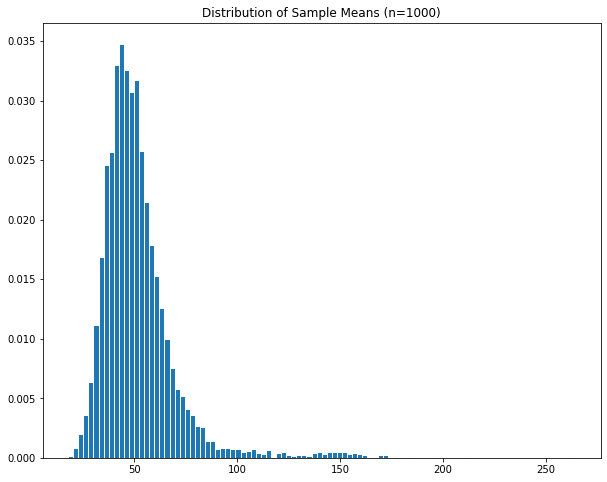

In [ ]:
#create an empty list to store sample means
sample_means=[]

# loop 10,000 times.
for i in range(0,10000):
    sample= df['income'].sample(10, replace=True) # draw a sample of 10 observations from the income variable, with replacement
    sample_mean=sample.mean() # calculate the mean of the sample
    sample_means.append(sample_mean) # append the sample mean to the list of sample means
    
plt.hist(sample_means, bins=100, edgecolor='white', density=True) # plot a histogram of the sample means
plt.title('Distribution of Sample Means (n=1000)')
plt.show()

### Exercise
 
    1. Edit the code block above so that instead of drawing samples of 10 observations, it draws samples of 1000 observations
    2. What happens to the distribution?

When we draw 10,000 samples of 1000 observations each, the distribution of sample means looks a lot more normally distributed than the underlying distribution of income itself, which is skewed to the right. To show how normally distributed it is, let's overlay the normal distribution line we plotted earlier and fit it to the distribution of sample means. We'll start off by making the same histogram of sample means, but add a line plot of the normal distribution and some droplines at ± 2 standard deviations. 

Because we may want to do this for several different variables, let's once again package our code as a function in which we can swap around a couple bits. In this case, we may want to swap around the variable we're plotting, the label on the x-axis, and the size of the samples we're drawing. So we'll create a function called `plot_sample_means` that takes these three things as arguments (`var`, `xlab`, and `sample_size`).

In [ ]:
def plot_sample_means(var, xlab, sample_size): # define a function called plot_sample_means that takes a variable, x-axis label, and sample size as arguments

    #create an empty list to store sample means
    sample_means=[]

    # loop 10,000 times.
    for i in range(0,10000):
        # for each iteration, draw a sample of the size specified by the "sample_size" parameter
        sample=var.sample(sample_size, replace=True)
        # calculate the mean, and append it to the list of sample means. 
        sample_mean=sample.mean()
        sample_means.append(sample_mean)
    
    # now, plot a histogram 
    plt.hist(sample_means, bins=int(30), edgecolor='white', density=True)
    
    # fit a normal distribution to the data 
    mu, se = norm.fit(sample_means)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, se) 
    plt.plot(x, p, 'k', linewidth=2)

    # calculate the difference between the mean of the sample means 
    diff=abs(mu-var.mean())
    
    # add droplines, labels, title, legend, and limit the x-axis range to 3 standard deviations from the mean on either side.
    plt.axvline(mu, color='red', linestyle='dashed', linewidth=1,label='µx̄='+str(round(mu, 3)))
    plt.axvline(mu-se*2, color='black', linestyle='dashed', linewidth=1.5,label='µ ± 2σ')
    plt.axvline(mu+se*2, color='black', linestyle='dashed', linewidth=1.5)
    plt.legend()
    plt.xlabel(xlab)	
    plt.title('Distribution of Sample Means (n={})'.format(sample_size))
    plt.xlim(mu-se*3, mu+se*3)
    plt.show()	

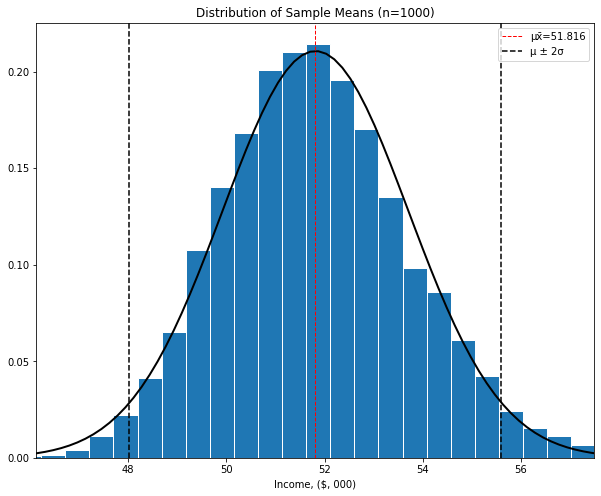

In [ ]:
plot_sample_means(df['income'], xlab='Income, ($, 000)', sample_size=1000)

We can see that the distribution of sample means (for samples of 1000 people) very closely approximates the normal distribution. The addition of droplines at ±2σ tells us that **if we take a random sample of 1000 people, there is a 95% chance that the mean of this sample will fall between ~$48k and ~$56k**. 

Why is this important? let's see what happens when we filter the sample based on peoples' attributes. The code below creates two dataframes: one called `men` which only contains male respondents, and one called `women` which only contains female respondents. Then, we run the `plot_sample_means()` function on each of these dataframes. 

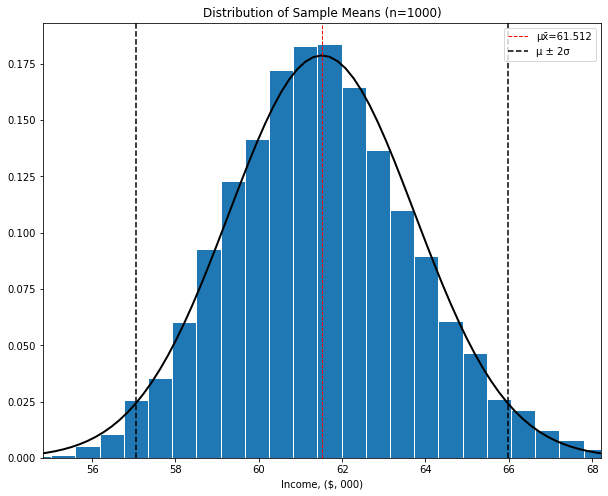

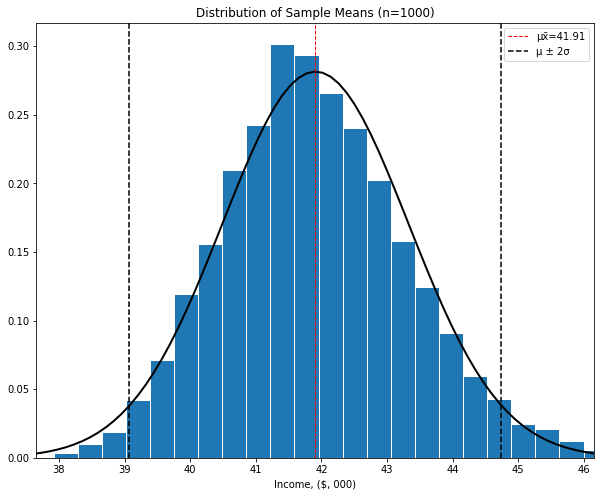

In [ ]:
men=df[df['sex']==1]['income'] # create a new dataframe containing only income values for men
women=df[df['sex']==2]['income'] # create a new dataframe containing only income values for women

plot_sample_means(men, xlab='Income, ($, 000)', sample_size=1000)
plot_sample_means(women, xlab='Income, ($, 000)', sample_size=1000)

### Exercise

    1. These two histograms may look the same, but look closely at the values. 
    2. The population mean income for women is around $42k. Based on the histogram of sample means taken from only men, 
        * What is the likelihood of observing a sample mean of $42k among men due to random chance?
    3. Interpret this finding qualitatively.

The plot of incomes for men and women show very different distributions, but they look quite similar. To make this more readable, let's define one last function that can take two or more groups and plot the distribution of their sample means on the same plot: 

In [ ]:
def two_hist(groups,group_labs,xlab, title): # define a function called two_hist that takes a list of groups, a list of group labels, an x-axis label, and a title as arguments

		plt.figure(figsize=(15,6)) # set the figure size

		it=-1 # create a counter variable called "it" and set it equal to -1
		for var in groups: # loop through each group in the list of groups
			it+=1 # increase the iterator by 1
			sample_size=1000 # set the sample size equal to 1000
			sample_means=[] # create an empty list to store sample means
			iterations=10000 # set the number of iterations equal to 10,000

			for i in range(0,iterations): # loop through the number of iterations
				sample=var.sample(sample_size, replace=True) # draw a sample of the size specified by the "sample_size" parameter
				sample_mean=sample.mean() # calculate the mean of the sample
				sample_means.append(sample_mean) # append the sample mean to the list of sample means
			
			plt.hist(sample_means, bins=int(iterations/300),edgecolor='white',density=True, label=group_labs[it])  # plot a histogram of the sample means
			mu, std = norm.fit(sample_means) # fit a normal distribution to the data
			xmin, xmax = plt.xlim() # set the x-axis limits
			x = np.linspace(xmin, xmax, 100) # create a range of values from the minimum to the maximum x-axis value
			p = norm.pdf(x, mu, std) # calculate the probability density function for the normal distribution

			plt.plot(x, p, 'k', linewidth=2) # plot the normal distribution

			plt.xlabel(xlab) # add an x-axis label
			plt.title(title) # add a title
			
			plt.axvline(var.mean(), color='red', linestyle='solid', linewidth=2) # add a vertical line at the mean of the variable
			plt.legend() # add a legend
			
		plt.show()  # show the plot	
		plt.close()

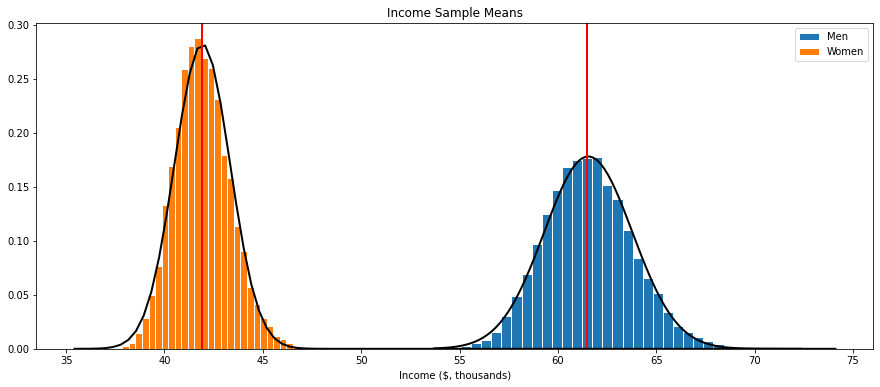

In [ ]:
two_hist([men,women],['Men','Women'],'Income ($, thousands)', "Income Sample Means")

There we have it: A stark, quantitative representation of the gender wage gap. 

If we simply compared the means between a sample of women and a sample of men, the best we could do in terms of inference would be to say something like "the average income for men was $19k higher than it was for women." Though this is an important finding, the central limit theorem lets us add important context. 

    1. We took 10,000 large samples of men and calculated the means of each sample.
    2. We found that over 99.7% of them were greater than $55,000. 
    3. We took 10,000 large samples of women and calculated the means of each sample.
    4. We found that over 99.7% of them were smaller than $47,000.

The fact that the distribution of income sample means between men and women do not overlap at all tells us that the probability of this variation in incomes being due to random chance is extremely, extremely small. Thus, we can say that the observed difference in income between men and women is **statistically significant**. We'll delve more in to what that means next week. 

## Extension

Given that we've used functions to create these plots, we can make plots with different data relatively easily. Intersectionality is an important consideration when thinking about inequality. The code below allows you to create a subset of income for white men: 

`w_men=df[(df['sex']==1)&(df['race']==1)]['income']`

There is a strong gendered difference in income, but what about the effects of both race and gender? How does union membership mitigate these inequalities? What if we only compare people in the same types of jobs? Try creating subsets based on these characteristics and plotting distributions of sample means to answer these questions. 